In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import RandomOverSampler

Carregando os datasets

In [2]:
train_ds = pd.read_csv('data/train.csv')
test_ds = pd.read_csv('data/test.csv')

train_ds.drop(columns=['Unnamed: 0', 'id'], inplace=True)
test_ds.drop(columns=['Unnamed: 0', 'id'], inplace=True)

train_ds.head(10)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
5,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,1,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
6,Male,Loyal Customer,47,Personal Travel,Eco,1276,2,4,2,3,...,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
7,Female,Loyal Customer,52,Business travel,Business,2035,4,3,4,4,...,5,5,5,5,4,5,4,4,0.0,satisfied
8,Female,Loyal Customer,41,Business travel,Business,853,1,2,2,2,...,1,1,2,1,4,1,2,0,0.0,neutral or dissatisfied
9,Male,disloyal Customer,20,Business travel,Eco,1061,3,3,3,4,...,2,2,3,4,4,3,2,0,0.0,neutral or dissatisfied


In [3]:
train_ds.dtypes

Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

### Checanndo por outliers
Utilizaremos o interquartile range para detectar outliers. Consideramos como **possíveis** (a ser decidido com uma análise posterior) outliers valores que estão fora do intervalo `[q1 - 1.5*IQR, q3 + 1.5*IQR]`, onde q1 e q3 são os primeiro e segundo quartis, e IQR = Q3-Q1.

2291 outliers in Flight Distance


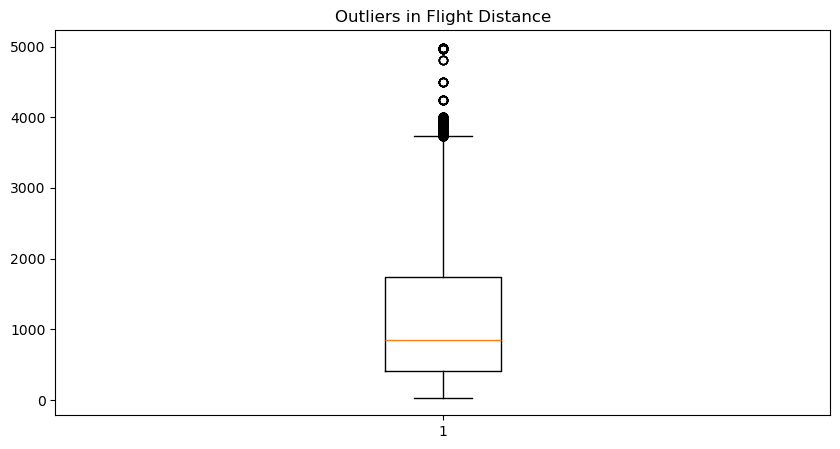

12891 outliers in Checkin service


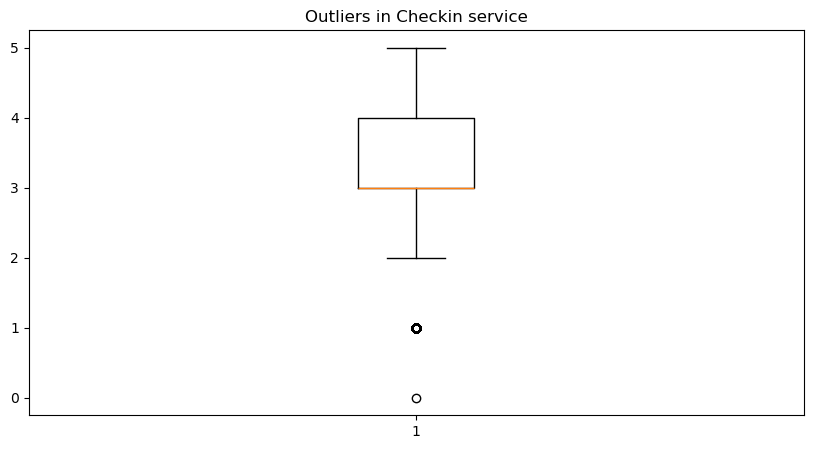

14529 outliers in Departure Delay in Minutes


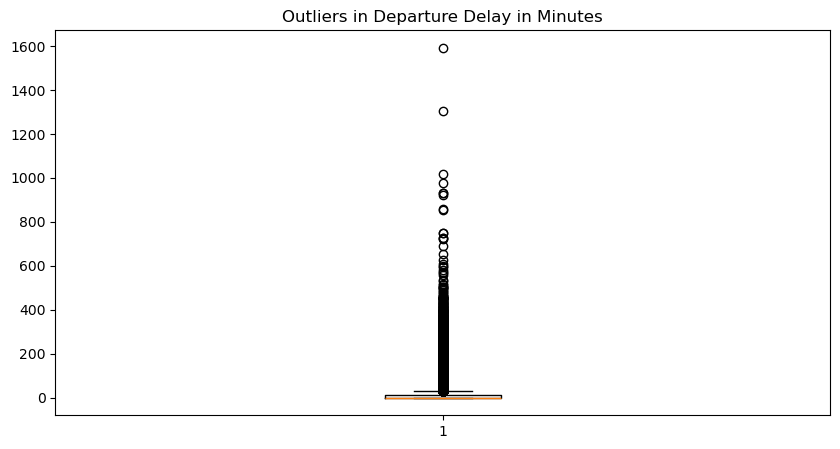

13954 outliers in Arrival Delay in Minutes


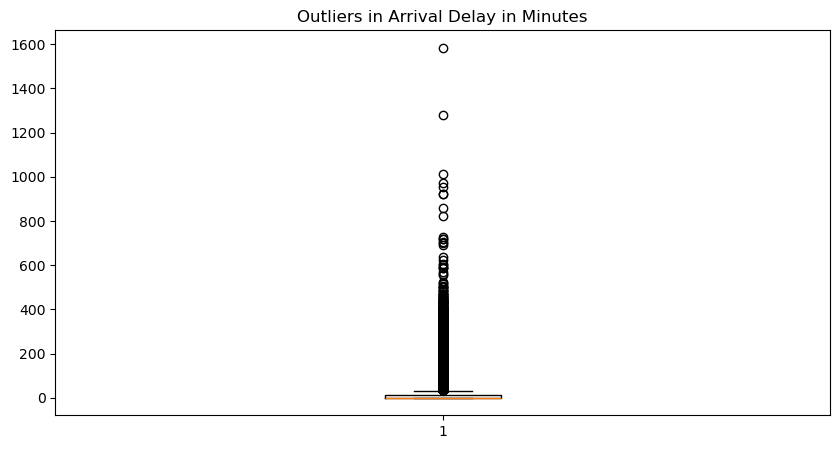

In [4]:
def check_outliers(df: pd.DataFrame):
    numeric_columns = df.select_dtypes(include='number')

    q1 = numeric_columns.quantile(0.25)
    q3 = numeric_columns.quantile(0.75)
    iqr = q3-q1

    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr

    outliers = (numeric_columns < lower_bound) | (numeric_columns > upper_bound)

    for column in numeric_columns.columns:
        n_outliers = outliers[column].sum()

        if n_outliers:
            print(f"{n_outliers} outliers in {column}")

            # Plotting the column with outliers
            plt.figure(figsize=(10, 5))
            plt.title(f'Outliers in {column}')
            plt.boxplot(df[column].dropna())
            plt.show()
        

check_outliers(train_ds)

Não consideraremos a coluna Checkin Service no tratamento de outliers, pois não acreditamos que há outliers, considerando que são valores discretos entre 1 e 5. Também iremos desconsiderar Flight Distance, pois, por conhecimento de domínio, de viagens áreas, observamos que esses valores (até cerca de 5,000 km) não configuram distâncias irreais para vôos. Seguiremos para o tratamento das colunas Departure Delay in Minutes e Arrival Delay in Minutes.

In [5]:
def remove_outliers(df: pd.DataFrame, columns):
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        median_value = df[column].median()

        df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), median_value, df[column])
    
    return df


train_ds = remove_outliers(train_ds, ['Departure Delay in Minutes', 'Arrival Delay in Minutes'])

2291 outliers in Flight Distance


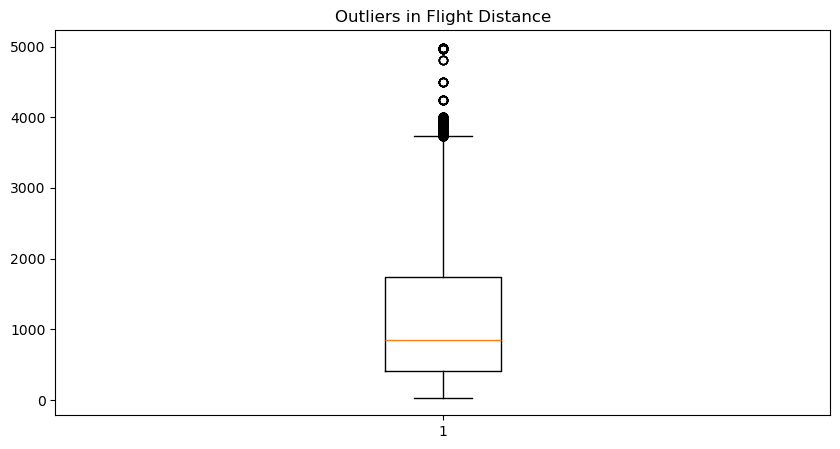

12891 outliers in Checkin service


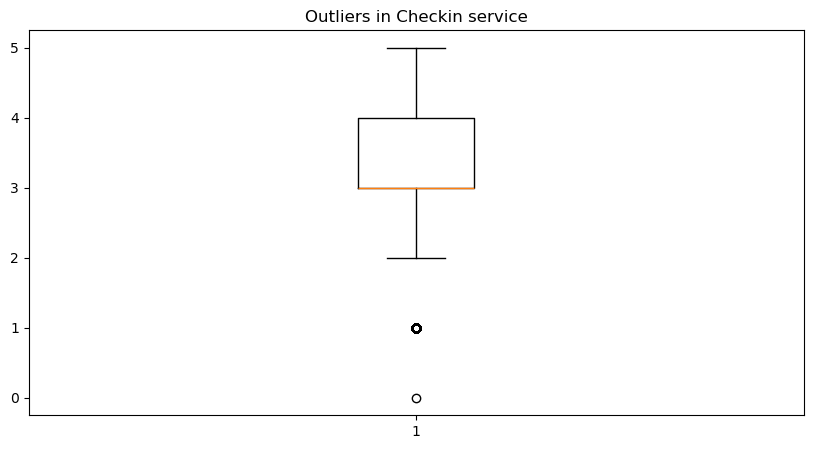

19930 outliers in Departure Delay in Minutes


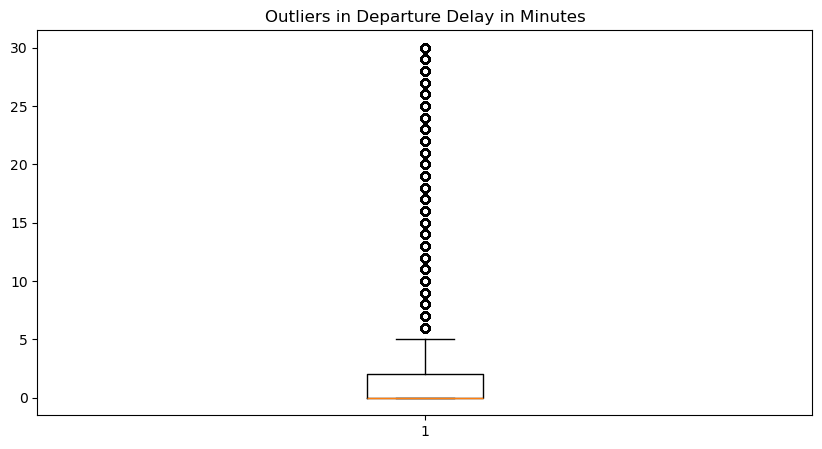

18592 outliers in Arrival Delay in Minutes


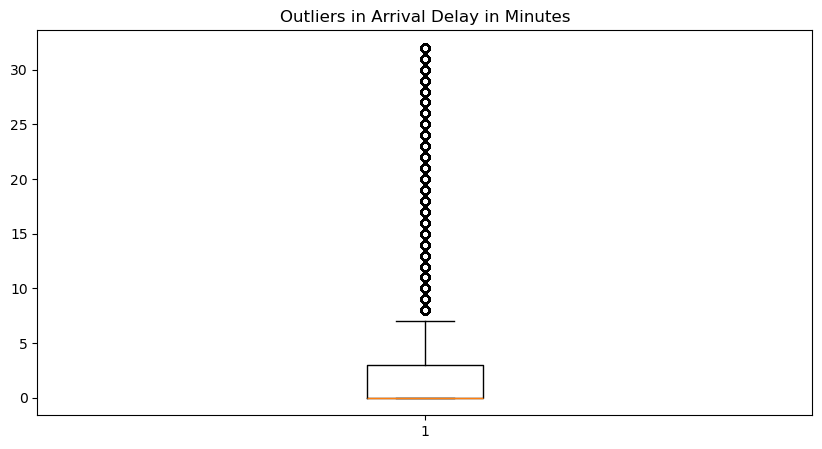

In [6]:
check_outliers(train_ds)

### Lidando com valores ausentes

In [7]:
def fill_null_values(df: pd.DataFrame):
    for column in df.columns:
        null_values = df[column].isnull().sum()

        if null_values:
            print(f"{column} has {null_values} missing values")
            if pd.api.types.is_numeric_dtype(df[column]):
                mean = df[column].mean()
                print(f'Imputing with {mean}')
                df[column].fillna(mean, inplace=True)

            else:
                print(f'Imputing with \'0000\'')
                df[column].fillna('0000', inplace=True)
    
    return df

train_ds = fill_null_values(train_ds)
print("--------------")
test_ds = fill_null_values(test_ds)

Arrival Delay in Minutes has 310 missing values
Imputing with 3.5554472266733597
--------------
Arrival Delay in Minutes has 83 missing values
Imputing with 14.74085660217047


/var/folders/td/6s38kfns7m30h4yz8m9_0r6m0000gn/T/ipykernel_34243/2210522116.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mean, inplace=True)


### Data Binning


In [8]:
def categorize_age(df: pd.DataFrame):
    # Inicializar as novas colunas com 0
    df['Jovem'] = 0
    df['Adulto'] = 0
    df['Idoso'] = 0


    df.loc[df['Age'] <= 20, 'Jovem'] = 1
    df.loc[(df['Age'] > 20) & (df['Age'] < 60), 'Adulto'] = 1
    df.loc[df['Age'] >= 60, 'Idoso'] = 1

    df.drop(columns='Age', inplace=True)

    return df

train_ds = categorize_age(train_ds)
test_ds = categorize_age(test_ds)

### Normalização

In [9]:
def normalize(df_train: pd.DataFrame, df_test: pd.DataFrame):
    numeric_data = df_test.select_dtypes(include='number')

    min_value = df_train[numeric_data.columns].min()
    difference = df_train[numeric_data.columns].max() - min_value
    

    df_train[numeric_data.columns] = (df_train[numeric_data.columns] - min_value) / difference

    df_test[numeric_data.columns] = (df_test[numeric_data.columns] - min_value) / difference
    
    return df_train, df_test


train_ds, test_ds = normalize(train_ds, test_ds)

In [10]:
train_ds.describe()

,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Jovem,Adulto,Idoso
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,0.233935,0.545937,0.612059,0.551380,0.595377,0.640426,0.650075,0.687879,0.671632,0.676473,0.670211,0.657958,0.660858,0.728086,0.657270,0.106712,0.111108,0.109072,0.797390,0.093538
std,0.201363,0.265566,0.305015,0.279786,0.255524,0.265907,0.269902,0.263818,0.266598,0.257671,0.263121,0.295226,0.253079,0.235133,0.262455,0.222568,0.223780,0.311731,0.401946,0.291187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.077342,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.500000,0.600000,0.600000,0.400000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.163974,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.800000,0.800000,0.800000,0.800000,0.750000,0.600000,0.800000,0.600000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.345719,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,1.000000,0.800000,0.800000,0.800000,1.000000,0.800000,1.000000,0.800000,0.066667,0.093750,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
test_ds.describe()

,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Jovem,Adulto,Idoso
count,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000
mean,0.234812,0.544949,0.609362,0.551355,0.595419,0.643071,0.652333,0.689844,0.671551,0.677133,0.670034,0.658310,0.662835,0.729851,0.657245,0.476870,0.460652,0.104905,0.799007,0.096089
std,0.201673,0.267077,0.306674,0.282590,0.256427,0.266301,0.271107,0.264018,0.267660,0.256418,0.263772,0.294131,0.253866,0.236136,0.263866,1.247439,1.170548,0.306436,0.400751,0.294719
min,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.077342,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.500000,0.600000,0.600000,0.400000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.165186,0.600000,0.600000,0.600000,0.600000,0.600000,0.800000,0.800000,0.800000,0.800000,0.800000,0.750000,0.600000,0.800000,0.600000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.345921,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,1.000000,0.800000,0.800000,0.800000,1.000000,0.800000,1.000000,0.800000,0.400000,0.406250,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,37.600000,34.843750,1.000000,1.000000,1.000000


### Codificando variáveis categóricas em variáveis numéricas

In [12]:
train_ds.dtypes

Gender                                object
Customer Type                         object
Type of Travel                        object
Class                                 object
Flight Distance                      float64
Inflight wifi service                float64
Departure/Arrival time convenient    float64
Ease of Online booking               float64
Gate location                        float64
Food and drink                       float64
Online boarding                      float64
Seat comfort                         float64
Inflight entertainment               float64
On-board service                     float64
Leg room service                     float64
Baggage handling                     float64
Checkin service                      float64
Inflight service                     float64
Cleanliness                          float64
Departure Delay in Minutes           float64
Arrival Delay in Minutes             float64
satisfaction                          object
Jovem     

In [13]:
for column in train_ds.select_dtypes(include='object'):
    print(train_ds[column].unique())

['Male' 'Female']
['Loyal Customer' 'disloyal Customer']
['Personal Travel' 'Business travel']
['Eco Plus' 'Business' 'Eco']
['neutral or dissatisfied' 'satisfied']


In [14]:
def encode(df: pd.DataFrame):
    category_columns = df.select_dtypes(include='object')
    
    encoder = OneHotEncoder(sparse_output=False, drop='first')    
    encoded_columns = encoder.fit_transform(df[category_columns.columns])
    encoded_feature_names = encoder.get_feature_names_out(category_columns.columns)

    encoded_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names)
    df.drop(columns=category_columns.columns, inplace=True)
    df = pd.concat([df, encoded_df], axis=1)
    
    return df

train_ds = encode(train_ds)
    

In [15]:
train_ds.head()

,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,...,Arrival Delay in Minutes,Jovem,Adulto,Idoso,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied
0,0.086632,0.6,0.8,0.6,0.2,1.0,0.6,1.0,1.0,0.8,...,0.56250,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.041195,0.6,0.4,0.6,0.6,0.2,0.6,0.2,0.2,0.2,...,0.18750,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.224354,0.4,0.4,0.4,0.4,1.0,1.0,1.0,1.0,0.8,...,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.107229,0.4,1.0,1.0,1.0,0.4,0.4,0.4,0.4,0.4,...,0.28125,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.036955,0.6,0.6,0.6,0.6,0.8,1.0,1.0,0.6,0.6,...,0.00000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [16]:
test_ds = encode(test_ds)
test_ds.head()

,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,...,Arrival Delay in Minutes,Jovem,Adulto,Idoso,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied
0,0.026050,1.0,0.8,0.6,0.8,0.6,0.8,0.6,1.0,1.0,...,1.3750,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.571890,0.2,0.2,0.6,0.2,1.0,0.8,1.0,0.8,0.8,...,0.0000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.032512,0.4,0.0,0.4,0.8,0.4,0.4,0.4,0.4,0.8,...,0.0000,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
3,0.675687,0.0,0.0,0.0,0.4,0.6,0.8,0.8,0.2,0.2,...,0.1875,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.232431,0.4,0.6,0.8,0.6,0.8,0.2,0.4,0.4,0.4,...,0.6250,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### Random Oversampling

In [17]:
train_ds['satisfaction_satisfied'].value_counts()

satisfaction_satisfied
0.0    58879
1.0    45025
Name: count, dtype: int64

In [18]:
data = train_ds.drop(columns=['satisfaction_satisfied'])
labels = train_ds['satisfaction_satisfied']


ros = RandomOverSampler(random_state=42)

data_resampled, labels_resampled = ros.fit_resample(data, labels)

resampled_df = pd.DataFrame(data_resampled, columns=data_resampled.columns)
resampled_df['satisfaction_satisfied'] = labels_resampled

print(resampled_df['satisfaction_satisfied'].value_counts())

satisfaction_satisfied
0.0    58879
1.0    58879
Name: count, dtype: int64


In [19]:
train_ds.to_csv('data/train_processed.csv', index=False)
test_ds.to_csv('data/test_processed.csv', index=False)